# Project: Google Landmark Recognition Challenge
## Domain Background
The Google landmark Recognition Challenge on Kaggle is selected to be a capstone project [1]. This topic is interested to me not only that the image recognition is a fundamental problem in computer vision of machine learning but also that this type of question is always faced in the real world.
It is a good topic to a machine-learning beginner because we have learned similar problem in Udacity classes. However, how to apply what we learned into a real case is a totally different scenario. If we can try to solve this type of problem, it will give us an experience of interacting and dealing with a real world case during the problem solving process. On the other hand, landmark recognition is useful to remind users what it is or introduce it to travelers who pass by. For example, travelers took a picture with a building, but forgot the name of this building when they try to put some information on social media or share to their friends. By using this recognition tool, it is easy to remind travelers what the building is. Moreover, when people see a landmark, they would like to know more information of it. This machine-learning model can recognize this image and provides a specifiec information to people.
## Problem Statement
The landmark recognition is a typical problem of computer vision. However, it is a little different from the regular problem. In this case, there are 15k classes of landmarks. The traditional image recognition on ImageNet is able to recognize 1k classes. That means the difficulty is how to recognize this large number of classes. The basic idea is building a CNN model and trains this model, but it causes much computation time to reach an acceptable accuracy. The potential solution is using a better architecture or transferring learning to reduce the computation time and get higher accuracy.
## Evaluation Metrics
The evaluation metrics is Global Average Precession (GAP) at k, where k=1 [3]. For each image, the model has to predict its landmark with confidence score. If there are N predictions for one image, the predictions should be sorted by their confidence score and apply to a function as follows. The evaluation function will not be implemented becasue the test result will send to Kaggle and Kaggle will provide the test GAP.  
$$GAP = \frac{1}{M}\sum_{i=1}^N P(i) rel(i)$$
where:
* N is the total number of predictions returned by the system, across all
queries
* M is the total number of queries with at least one landmark from the training
set visible in it (note that some queries may not depict landmarks)
* P(i) is the precision at rank i
* Rel(i) denotes the relevance of prediction i: it’s 1 if the i-th prediction is
correct and 0 otherwise


# Analysis
## Data Exploration
Before training a model, a data exploration has to be applied. First, using basic pandas function obtains datasets' information such as data size, format, and data distribution.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from tqdm import tqdm
from keras.utils import np_utils
%matplotlib inline

C:\Users\Gamer\Anaconda3\envs\tfgpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Load dataset and check the size of train data and test data whichi is provided by the website.

In [2]:
# load train csv file
train_csv = pd.read_csv('data/train/train.csv')
# show the size of the train data
print(train_csv.shape)
# load test csv file
test_csv = pd.read_csv('data/test/test.csv')
# show the size of the test data
print(test_csv.shape)

(1225029, 3)
(117703, 2)


Display the data set and show some data samples.

In [3]:
train_csv.head(5)

,id,url,landmark_id
0,cacf8152e2d2ae60,http://static.panoramio.com/photos/original/70...,4676
1,0a58358a2afd3e4e,http://lh6.ggpht.com/-igpT6wu0mIA/ROV8HnUuABI/...,6651
2,6b2bb500b6a38aa0,http://lh6.ggpht.com/-vKr5G5MEusk/SR6r6SJi6mI/...,11284
3,b399f09dee9c3c67,https://lh3.googleusercontent.com/-LOW2cjAqubA...,8429
4,19ace29d77a5be66,https://lh5.googleusercontent.com/-tnmSXwQcWL8...,6231


In [4]:
test_csv.head()

,id,url
0,000088da12d664db,https://lh3.googleusercontent.com/-k45wfamuhT8...
1,0001623c6d808702,https://lh3.googleusercontent.com/-OQ0ywv8KVIA...
2,0001bbb682d45002,https://lh3.googleusercontent.com/-kloLenz1xZk...
3,0002362830cfe3a3,https://lh3.googleusercontent.com/-N6z79jNZYTg...
4,000270c9100de789,https://lh3.googleusercontent.com/-keriHaVOq1U...


According to the above information, the train dataset contains three attributes, id, url, and landmark_id. The following is an example of train dataset.  

| id 	| url 	| landmark_id 	|
|:-----:	|:------:	|:-----------:	|
|   cacf8152e2d2ae60  	|  http://static.panoramio.com/photos/original/70... | 4676|

The test dataset contains two attibutes, id and url. The test dataset is shown as follows:

| id 	| url 	|
|:-----:	|:------:	|
|   000088da12d664db 	|  https://lh3.googleusercontent.com/-k45wfamuhT8... |

That means images are downloaded through these urls and tag these images with landmark_id for train datasets. The real train and test images should be downloaded separately.

Check the landmark train data statistics to see if there is abnormal datasets.


(14951, 2)
### Most Frequent landmark_id ###
   landmark_id  count
0         9633  50337
1         6051  50148
2         6599  23415
3         9779  18471
4         2061  13271
### Least Frequent landmark_id ###
       landmark_id  count
14946         1527      1
14947         6025      1
14948         4334      1
14949         5865      1
14950         8381      1


C:\Users\Gamer\Anaconda3\envs\tfgpu\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


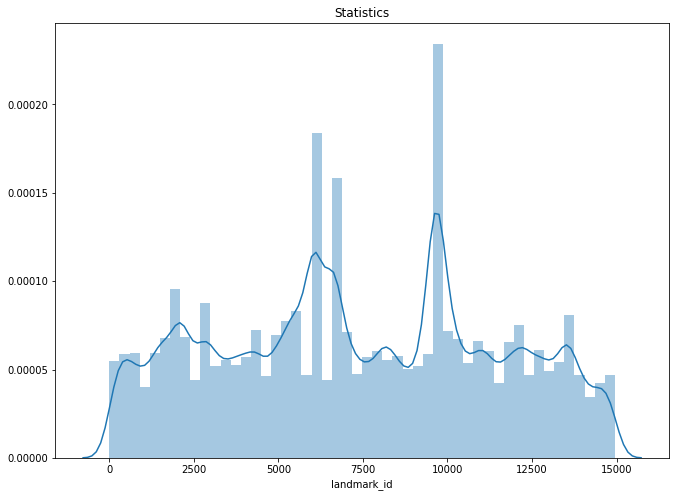

In [5]:
# get the image frequent of each landmark
train_stat = pd.DataFrame(train_csv.landmark_id.value_counts())
train_stat.reset_index(inplace=True)
train_stat.columns=['landmark_id','count']
print(train_stat.shape)
print('### Most Frequent landmark_id ###')
print(train_stat.head())
print('### Least Frequent landmark_id ###')
print(train_stat.tail())
# plot image frequent 
plt.figure(figsize = (11, 8))
plt.title('Statistics')
sns.distplot(train_csv['landmark_id'])
plt.show()

According to the above frequence chart of landmarks, it shows that some landmark contain many images for training bu t some landmarks contain only one image. This train dataset is highly skewed.

## Exploratory Visualization
Defore downloading all datasets, some images will be downloaded first to show image specification.

In [6]:
from IPython.display import Image
from IPython.core.display import HTML 

def category_image(urls):
    imagesHTML = ''.join(["<img style='{img_style}' src='{u}' />".
                          format(img_style="width: 180px; margin: 0px; float: left; border: 1px solid black;",
                                 u=val) 
                          for key, val in urls.iteritems()])
    display(HTML(imagesHTML))

urls = train_csv['url'][100:105]
category_image(urls)

After exploration the dataset, images contains various dimensions so a resizing function has to be applied before training the model. There are 1,225,029 images and 14,951 classes in the training dataset. However, the image examples are not balance. Some landmarks only contain one image, and some landmarks contain more than 50k images. 

### Download train and test data  
There is a saperate code in this folder called d.py.  
This program will donwnload the images from website and resize image dimensions to 224 X 224. Also, it creates a trainImageList for train images which downloaded successfully, and a testImageList file for test images which downloaded successfully.  
The dataset is gigantic, so there are only 50% downloaded.

In [3]:
train = pd.read_csv('data/trainImagesList')
display(train.head(5))
display(train.shape)

,id,landmark_id,filename
0,4cddf5dfec480378,10900,data/trainImages/4cddf5dfec480378.jpg
1,e892105697730cd0,9633,data/trainImages/e892105697730cd0.jpg
2,e6ca7e6d1fb0c30e,7979,data/trainImages/e6ca7e6d1fb0c30e.jpg
3,5b7e170e3f82df79,8487,data/trainImages/5b7e170e3f82df79.jpg
4,8bb30ed8ded320b5,10045,data/trainImages/8bb30ed8ded320b5.jpg


(593365, 3)

In [2]:
test = pd.read_csv('data/testImagesList')
display(test.head(5))
display(test.shape)

,id,landmark_id,filename
0,000088da12d664db,None,data/testImages/000088da12d664db.jpg
1,0001623c6d808702,None,data/testImages/0001623c6d808702.jpg
2,0001bbb682d45002,None,data/testImages/0001bbb682d45002.jpg
3,0002362830cfe3a3,None,data/testImages/0002362830cfe3a3.jpg
4,000270c9100de789,None,data/testImages/000270c9100de789.jpg


(115698, 3)

When downloading, there is a image list file containing imgae infornation whichh has downlaoded successfully. In the image list file, there id, landmark_id and filename. The id and landmark_id are the same with the original dataset's. The onnly difference is that url is replaced by a filename. The filename can be used to get the downloaded image.   

| id 	|  landmark_id	|  filename	|
|:-----:	|:------:	|:-----------:	|
|   cacf8152e2d2ae60  	|  10900 | data/trainImages/4cddf5dfec480378.jpg|

For the test dataset, there is no landmark_id.

| id 	|  landmark_id	|  filename	|
|:-----:	|:------:	|:-----------:	|
|   0002362830cfe3a3  	|  None | data/testImages/0002362830cfe3a3.jpg|




## Algorithms and Techniques
Algorithms and techniques used in the project are thoroughly discussed and properly justified based on the characteristics of the problem.  
This is a typical image recgonition problem, so a CNN method will be applied in this project. The following steps will  be implemented.  
* Before training the data, there are several steps to preprocess data.
    * Select 100 examples from each class. If a class contains more than 100 examples, randomly select 100 of them. If a class contains less than 100 examples, use image generator (rotate, shift and zoom) creating examples to meet 100 training examples.
    * Image size will be normalized to 224 X 224.
* Using the benchmark model gets a GAP score as a benchmark score.
* Implement a basic CNN architecture
     * One convolution layer and one maxpooling layer repeat three times and the model ends with a fully connected layer.
* Implement transferring leaning. There four architecture will be tried, VGG-19, ResNet-50, Inception, and Xception.
* Compare the results of two architectures.
* Improve the GAP by using a better architecture which has implemented previously.  

## Benchmark
Currently, there is no existing model for this topic. A random guess model will be used. In the random guess model, the accuracy is roughly 1 in 15k since there are 15k classes. However, this dataset is not balance. If we chose the most frequent class in this dataset for every test, the result will be 4.1% accuracy (50337/1225029). Also, the precession of this model is 0.041.
$$𝑃𝑟𝑒𝑐𝑒𝑠𝑠𝑖𝑜𝑛 = \frac{𝑇𝑟𝑢𝑒 𝑃𝑜𝑠𝑖𝑡𝑖𝑣𝑒}{𝑇𝑟𝑢𝑒 𝑃𝑜𝑠𝑖𝑡𝑖𝑣𝑒 + 𝐹𝑙𝑎𝑠𝑒 𝑃𝑜𝑠𝑖𝑡𝑖𝑣𝑒}= \frac{50337}{50337 + 1174692}=0.041$$
Therefore, if one example image contains one landmark (M = 1) and this model predicts the landmark correctly with one solution (P(1) = 0.041, rel(1) = 1), the GAP
will be 0.041.
$$GAP = \frac{1}{M}\sum_{i=1}^N P(i) rel(i)= \frac{1}{1}\sum_{i=1}^1 P(i) rel(i)= P(1) rel(1)= 0.041$$

,landmark_id,count
0,9633,24322
1,6051,24167
2,6599,11235
3,9779,9092
4,2061,6334


,landmark_id,count
14558,3005,1
14559,956,1
14560,9012,1
14561,208,1
14562,2129,1


(14563, 2)

C:\Users\Gamer\Anaconda3\envs\tfgpu\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


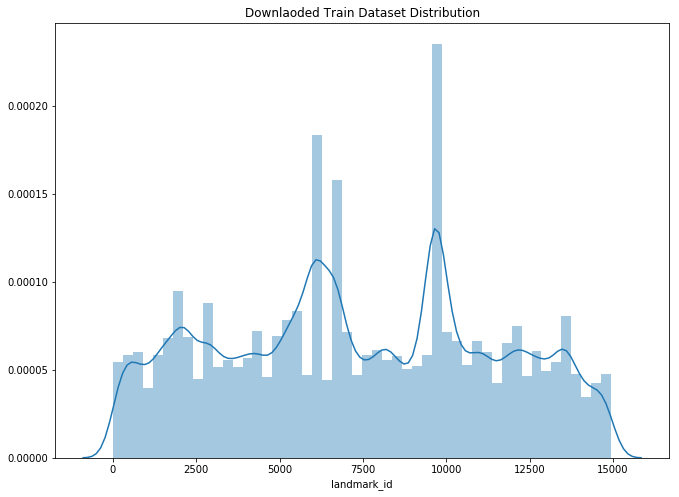

In [9]:
# Get the landmark frequent of downloaded images.
train_bm = pd.DataFrame(train.landmark_id.value_counts())
train_bm.reset_index(inplace=True)
train_bm.columns = ['landmark_id','count']
display(train_bm.head())
display(train_bm.tail())
display(train_bm.shape)
plt.figure(figsize = (11,8))
plt.title('Downlaoded Train Dataset Distribution')
sns.distplot(train['landmark_id'])
plt.show()

According to the above plot, the landmark 9633 has the most frequent. If an algorithm always recgonize an image with id 9633, the accuracy will be close to 4%.

In [10]:
# If the algorithm predicts the image correctly, add one to bm_correct
bm_correct = 0
# The lankmark_id which the algorithm will predict 
bm_guess = 9633

for landmark_id in train['landmark_id']:
    # always predict the image with the same landmark_id
    if landmark_id == 9633:
        bm_correct += 1
print('Accuracy: {x} %'.format(x=100*bm_correct/len(train['landmark_id'])))

Accuracy: 4.098994716574116 %


The above algorithm always has the same prediction, and the accuracy is 4.09899% which is close to 4%.

# Methodology
## Data Preprocessing
To avoid creating the relationship between the train dataset and test dataset, the test dataset will be only used for testing. The train dataset will be separated in two secitons, the training dataset and the valid dataset. 

In [11]:
train_rows = pd.DataFrame()
valid_rows = pd.DataFrame()

landmarks = pd.DataFrame(train['landmark_id'])
landmarks = landmarks.drop_duplicates()
display(landmarks.head())
print(landmarks.shape)
for landmark_id in tqdm(landmarks['landmark_id']):
    rows = train[ train['landmark_id'] == landmark_id]
    if len(rows.index) > 100:
        samples = rows.sample(n=100)
        rest = rows.drop(samples.index)
        train_rows = train_rows.append(samples)
        valid_rows = valid_rows.append(rest)
    elif len(rows.index) == 1:
        train_rows = train_rows.append(rows)
    else:
        samples = rows.sample(n=1)
        rest = rows.drop(samples.index)
        train_rows = train_rows.append(samples)
        valid_rows = valid_rows.append(rest)

display(train_rows.head())
display(train_rows.shape)
display(valid_rows.head())
display(valid_rows.shape)

,landmark_id
0,10900
1,9633
2,7979
3,8487
4,10045


(14563, 1)


100%|████████████████████████████████████| 14563/14563 [34:07<00:00,  7.11it/s]


,id,landmark_id,filename
46171,f4d33bde35414fa9,10900,data/trainImages/f4d33bde35414fa9.jpg
295084,1c46a155a04383dc,10900,data/trainImages/1c46a155a04383dc.jpg
389777,95a12bfaab5d62ef,10900,data/trainImages/95a12bfaab5d62ef.jpg
215482,3873bebd998e66c2,10900,data/trainImages/3873bebd998e66c2.jpg
544913,80b25fd086f3893d,10900,data/trainImages/80b25fd086f3893d.jpg


(119899, 3)

,id,landmark_id,filename
0,4cddf5dfec480378,10900,data/trainImages/4cddf5dfec480378.jpg
226,5f9ee6dad5124453,10900,data/trainImages/5f9ee6dad5124453.jpg
300,28575f73cf928ef2,10900,data/trainImages/28575f73cf928ef2.jpg
644,f5a9837932e8f121,10900,data/trainImages/f5a9837932e8f121.jpg
940,aef122f519be2d68,10900,data/trainImages/aef122f519be2d68.jpg


(473466, 3)

For the convenience, both data frame are stored. They can be loaded in the future.

In [14]:
train_rows.to_csv('data/train_rows.csv', sep=',', index=False)
valid_rows.to_csv('data/valid_rows.csv', sep=',', index=False)

In [2]:
train_rows = pd.read_csv('data/train_rows.csv')
valid_rows = pd.read_csv('data/valid_rows.csv')

Let's check if the random selected test rows is balanced.

,landmark_id,count
0,11423,100
1,10028,100
2,9155,100
3,5479,100
4,3788,100


,landmark_id,count
14558,9837,1
14559,11884,1
14560,7786,1
14561,3688,1
14562,0,1


C:\Users\Gamer\Anaconda3\envs\tfgpu\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


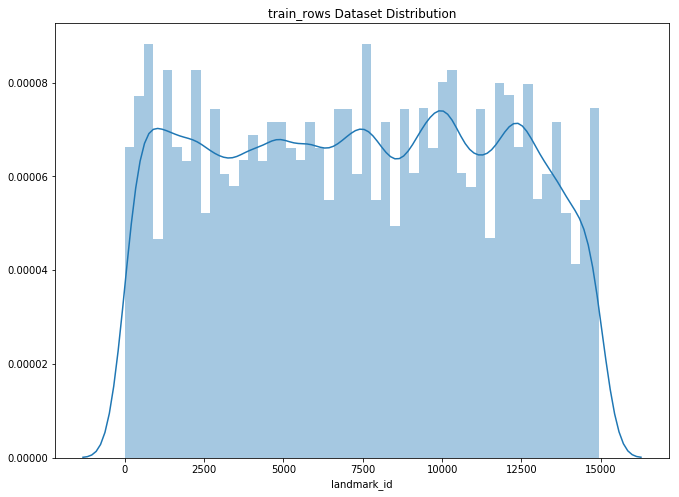

In [12]:
train_rows_stat = pd.DataFrame(train_rows.landmark_id.value_counts())
train_rows_stat.reset_index(inplace=True)
train_rows_stat.columns = ['landmark_id','count']
display(train_rows_stat.head())
display(train_rows_stat.tail())

plt.figure(figsize = (11,8))
plt.title('train_rows Dataset Distribution')
sns.distplot(train_rows['landmark_id'])
plt.show()
# plt.figure(figsize = (11,8))
# plt.title('train_rows Dataset Distribution')
# sns.distplot(valid_rows['landmark_id'])
# plt.show()

The train dataset is not balanced. There are several landmarks containing less than 100 images. The following will apply an image generater to balance train dataset.

In [3]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

['data/2e59d84de48709dd_0.jpg']


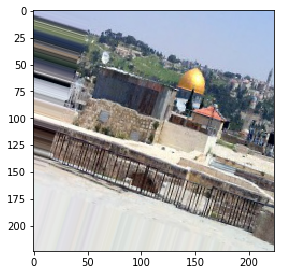

In [14]:
datagen = ImageDataGenerator(rotation_range=30.0, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             brightness_range=None, 
                             shear_range=0.0, 
                             zoom_range=0.0, 
                             fill_mode='nearest', 
                             horizontal_flip=True, 
                             rescale=None)

def imgGenerator(file_path, nums, output_folder, showImage=False):
    '''
        Image generator function
        Argument:
            file_path - the image file path which will be used to generate new images
            nums - how many number of images will be generated
            output_folder - the folder which will contain the agument image
            showImage - if True, display the agument image
    '''
    resultImageList = []
    newImages = pd.DataFrame()
    previewImg = load_img(file_path)
    inputImg = img_to_array(previewImg)
    inputImg = inputImg.reshape((1,) + inputImg.shape)
    i = 0
    columns = 5
    # get the out file prefix based on the input file name.
    file_prefix = file_path.split('/')[-1].split('.')[0]
    # print(file_prefix)
    # image display initializer
    dataFig = plt.figure(figsize=(25,25))
    for batch in datagen.flow(inputImg, batch_size=1):
        # Check if the file exists.
        fileName = "{z}/{x}_{y}.jpg".format(z=output_folder,x=file_prefix, y=i)
        # append to the image information list
        resultImageList.append(fileName)
        # check if the file exists
        if os.path.exists(fileName):
            i = i + 1
            if i >= nums:
                break
            continue
        try:
            # convert to image file
            imageToSave = array_to_img(batch[0])
            # save the agument image
            imageToSave.save(fileName, format='JPEG', quality=90)
            # if True, show generated images.
        except:
            print("cannot save image: {x}.".format(x=file_prefix))
            i=i+1
        if showImage:
            plt.subplot(nums / columns + 1, columns, i+1)
            plt.imshow(imageToSave)
        
        i = i + 1
        if i >= nums:
            break
    return resultImageList

# Take one example to show how the imaGenerator function creates new images.
images_new_list = imgGenerator(file_path = 'data/trainImages/2e59d84de48709dd.jpg', 
             nums = 1,
             output_folder = 'data', 
             showImage = True)
print(images_new_list)

In order to generate augment images, the following function is applied. The following cell will save all augment images and create a csv file recording images information including the file path and landmark id.

In [ ]:
# use image generator to increase train dataset image numbers
train_agument = pd.DataFrame(columns=['id','landmark_id','filename'])
# Iterator train dataset with landmark id
for t_row in tqdm(train_rows_stat.iterrows(), total=train_rows_stat.shape[0]):
    currnet_img_count = t_row[1]['count']
    # if the train dataset contrains 100 images, do not genrate new images
    if currnet_img_count == 100:
        continue
    # if the image count less than 100, generate new images.
    # how many images need to be generated
    img_augment_num = 100 - currnet_img_count
    # how many image can be generated by each existing image
    img_augment_rate = math.ceil(img_augment_num/currnet_img_count)
    # get the list of existing images.
    img_original = train_rows[train_rows['landmark_id'] == t_row[1]['landmark_id']]
    # iterator all existing images, and each image will generate the number of img_augment_rate.
    for i in range(img_original.shape[0]):
        images_new_list = imgGenerator(file_path = img_original.iloc[i]['filename'], 
                 nums = img_augment_rate,
                 output_folder = 'data/trainImagesExtend', 
                 showImage = False)
        # append the generated images information to a data frame.
        for filename in images_new_list:
            # Check if the data set contaions 100 image
            if img_augment_num <= 0:
                break
            
            img_id = filename.split('/')[-1].split('.')[0]
            train_agument.loc[train_agument.shape[0]] = [img_id, t_row[1]['landmark_id'], filename]
            # update the rest of image will be generated
            img_augment_num = img_augment_num -1

display(train_agument.head())
display(train_agument.shape)
train_agument.to_csv('data/train_agument.csv', sep=',', index=False)

In [4]:
train_agument = pd.read_csv('data/train_agument.csv')

After generating agumnet images, check if the train dataset is balance or not.

In [5]:
train_input = train_rows.append(train_agument)
train_input_stat = pd.DataFrame(train_input.landmark_id.value_counts())
train_input_stat.reset_index(inplace=True)
train_input_stat.columns = ['landmark_id','count']
display(train_input_stat.head())
display(train_input_stat.tail())

# plt.figure(figsize = (11,8))
# plt.title('train_input Dataset Distribution')
# sns.distplot(train_input['landmark_id'], color=['b'])
# plt.show()

,landmark_id,count
0,2047,100
1,13644,100
2,9544,100
3,6479,100
4,4430,100


,landmark_id,count
14558,6808,100
14559,11935,100
14560,9886,100
14561,3739,100
14562,0,100


The project will use Keras and TensorFlow to implement CNN architecture. Because using the TensorFlow as backend, every image data must be a 4-D array based on the Keras requirement.
$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$
The nb_samples refers to the number of images. The rows and columns are the dimension of the image, and the channels is the color layers of the image. For example, a RGB images has three layers.  

The path_to_tensor function will convert an image to a 4-D data array.  
The paths_to_tensor will generate a list of images as Keras CNNs' input.  
Both function is from the previous project, dog_app.

In [16]:
from keras.preprocessing import image 

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    #list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

There are too many train images so there are about 45000 images which will be used in this project.

In [6]:
# display(valid_rows.shape)
train_reduce = pd.DataFrame()
#print(train_input.shape[0]/100)
for i in range(int(train_input.shape[0]/100)):
    train_reduce = train_reduce.append(train_input.iloc[i*100:i*100+3])
    
display(train_reduce.shape)
display(train_reduce.head())
display(train_reduce.tail())

(43689, 3)

,id,landmark_id,filename
0,f4d33bde35414fa9,10900,data/trainImages/f4d33bde35414fa9.jpg
1,1c46a155a04383dc,10900,data/trainImages/1c46a155a04383dc.jpg
2,95a12bfaab5d62ef,10900,data/trainImages/95a12bfaab5d62ef.jpg
100,7b45663424a0be06,9633,data/trainImages/7b45663424a0be06.jpg
101,db91723b539f2564,9633,data/trainImages/db91723b539f2564.jpg


,id,landmark_id,filename
1336202,a66ebc5fe982287f_98,7786,data/trainImagesExtend/a66ebc5fe982287f_98.jpg
1336203,40512c8b0bac9388_0,3688,data/trainImagesExtend/40512c8b0bac9388_0.jpg
1336301,40512c8b0bac9388_98,3688,data/trainImagesExtend/40512c8b0bac9388_98.jpg
1336302,ed4faf172c181e34_0,0,data/trainImagesExtend/ed4faf172c181e34_0.jpg
1336303,ed4faf172c181e34_1,0,data/trainImagesExtend/ed4faf172c181e34_1.jpg


There are only two images for each lankmark to validate the model because the computer does not have enough memory.

In [7]:
valid_reduce = pd.DataFrame()
valid_rows.sort_values(by=['landmark_id'])
tmp_id = -1
for i in range(int(valid_rows.shape[0])):
    if tmp_id != valid_rows.iloc[i]['landmark_id']:
        valid_reduce = valid_reduce.append(valid_rows.iloc[i:i+1])
        tmp_id = valid_rows.iloc[i]['landmark_id']

display(valid_reduce.shape)
display(valid_reduce.head())

(13442, 3)

,id,landmark_id,filename
0,4cddf5dfec480378,10900,data/trainImages/4cddf5dfec480378.jpg
3371,e892105697730cd0,9633,data/trainImages/e892105697730cd0.jpg
27593,e6ca7e6d1fb0c30e,7979,data/trainImages/e6ca7e6d1fb0c30e.jpg
27635,dc64d067badb1d52,8487,data/trainImages/dc64d067badb1d52.jpg
27670,8bb30ed8ded320b5,10045,data/trainImages/8bb30ed8ded320b5.jpg


In [11]:
'''
    This cell will not be run because of the memory limitation
'''
# The first step is loading images.
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# get file list from previous data frame
train_files = np.array(train_reduce['filename'])
train_targets = np.array(train_reduce['landmark_id'])
valid_files = np.array(valid_reduce['filename'])
valid_targets = np.array(valid_reduce['landmark_id'])
test_files = np.array(test['filename'])

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████| 43689/43689 [22:15<00:00, 32.71it/s]


MemoryError: 

After trying load images to memory for many times, the system are not able to run this CNN because of the memory limitaion. This project only uses few images to run the process. Even though the result is not correct, the process is the same and these code can be use in a powerful computer. The following process only use 7500 images as train dataset, 1500 images as valid dataset, and 1500 images as test dataset.

In [6]:
train_reduce = pd.DataFrame()
# only select 7500 images as train inputs
for i in range(int(train_input.shape[0]/100)):
    if i >= 7500:
        break
    train_reduce = train_reduce.append(train_input.iloc[i*100])
    
display(train_reduce.shape)
display(train_reduce.head())
display(train_reduce.tail())

(3000, 3)

,filename,id,landmark_id
0,data/trainImages/f4d33bde35414fa9.jpg,f4d33bde35414fa9,10900.0
100,data/trainImages/7b45663424a0be06.jpg,7b45663424a0be06,9633.0
200,data/trainImages/9d1265db12e4ebb1.jpg,9d1265db12e4ebb1,7979.0
300,data/trainImages/89b80893361d7405.jpg,89b80893361d7405,8487.0
400,data/trainImages/7d8c5d0236f4bda4.jpg,7d8c5d0236f4bda4,10045.0


,filename,id,landmark_id
179601,data/trainImagesExtend/7638f33cc89a15d2_15.jpg,7638f33cc89a15d2_15,5342.0
179701,data/trainImagesExtend/99134ef5d6a3ed74_16.jpg,99134ef5d6a3ed74_16,7261.0
179801,data/trainImagesExtend/4b5a5d92a2213a89_17.jpg,4b5a5d92a2213a89_17,11355.0
179901,data/trainImagesExtend/0ed6388b70a26749_18.jpg,0ed6388b70a26749_18,9306.0
180001,data/trainImagesExtend/033f353093755617_19.jpg,033f353093755617_19,13400.0


In [7]:
# select 1500 images as valid dataset
valid_reduce = pd.DataFrame()
valid_rows.sort_values(by=['landmark_id'])
tmp_id = -1
for i in range(int(valid_rows.shape[0])):
    if valid_reduce.shape[0] >= 1500:
        break
    if tmp_id != valid_rows.iloc[i]['landmark_id']:
        valid_reduce = valid_reduce.append(valid_rows.iloc[i:i+1])
        tmp_id = valid_rows.iloc[i]['landmark_id']

display(valid_reduce.shape)
display(valid_reduce.head())

(1500, 3)

,id,landmark_id,filename
0,4cddf5dfec480378,10900,data/trainImages/4cddf5dfec480378.jpg
3371,e892105697730cd0,9633,data/trainImages/e892105697730cd0.jpg
27593,e6ca7e6d1fb0c30e,7979,data/trainImages/e6ca7e6d1fb0c30e.jpg
27635,dc64d067badb1d52,8487,data/trainImages/dc64d067badb1d52.jpg
27670,8bb30ed8ded320b5,10045,data/trainImages/8bb30ed8ded320b5.jpg


In [10]:
# only select 1500 images as test dataset
test_reduce = test.sample(n=1500)
display(test_reduce.shape)
display(test_reduce.head())

(1500, 3)

,id,landmark_id,filename
94797,d1dd4b0b44275d92,None,data/testImages/d1dd4b0b44275d92.jpg
61099,878b62dcdfe21cdb,None,data/testImages/878b62dcdfe21cdb.jpg
81717,b531027c52c02ea2,None,data/testImages/b531027c52c02ea2.jpg
20596,2dd23595bdcaab66,None,data/testImages/2dd23595bdcaab66.jpg
7491,10b267908402002e,None,data/testImages/10b267908402002e.jpg


In [10]:
# The first step is loading images.
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True

# get file list from previous data frame
train_files = np.array(train_reduce['filename'])
train_targets = np_utils.to_categorical(np.array(train_reduce['landmark_id']), 15000)
valid_files = np.array(valid_reduce['filename'])
valid_targets = np_utils.to_categorical(np.array(valid_reduce['landmark_id']), 15000)
# test_files = np.array(test_reduce['filename'])

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
# test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████████████████████████████████| 1500/1500 [00:19<00:00, 77.69it/s]


## Implementation
After we have available train, valid and test dataset, a simple CNN architacture can be applied. The first implementation is creating a base architacture. The architacture contains one convolution layer and one maxpooling layer as a base model and it repeats three times with one fully connected layer in the end. For each base model, there is a drop rate.


In [5]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

In [6]:
model = Sequential()

# base model
# 1st 
# convolution layer
model.add(Conv2D(filters=16, kernel_size=2, padding='same', input_shape=(224,224,3), activation='relu'))
# pooling layer
model.add(MaxPooling2D(pool_size=3))
# dropout
model.add(Dropout(0.25))

# 2nd
# convolution layer
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
# pooling layer
model.add(MaxPooling2D(pool_size=3))
# dropout
model.add(Dropout(0.25))

# 3rd
# convolution layer
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
# pooling layer
model.add(MaxPooling2D(pool_size=3))
# dropout
model.add(Dropout(0.25))

# 4th, Flatten
model.add(Flatten())

# 5th, Fully connected layer
model.add(Dense(15000, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 16)        1040      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 16)        1040      
__________

### Compile model

In [7]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model

In [6]:
from keras.callbacks import ModelCheckpoint

In [33]:
epochs = 5

checkpointer = ModelCheckpoint(filepath='saved_models/weight.best.base_model.hdf5', 
                              verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
         validation_data=(valid_tensors, valid_targets), 
         epochs = epochs, batch_size=20, callbacks=[checkpointer], verbose=2)

Train on 7500 samples, validate on 1500 samples
Epoch 1/5
 - 18s - loss: 1.7500 - acc: 0.6429 - val_loss: 13.7209 - val_acc: 0.0020

Epoch 00001: val_loss improved from inf to 13.72093, saving model to saved_models/weight.best.base_model.hdf5
Epoch 2/5
 - 18s - loss: 0.5636 - acc: 0.8696 - val_loss: 14.8638 - val_acc: 0.0020

Epoch 00002: val_loss did not improve
Epoch 3/5
 - 18s - loss: 0.2054 - acc: 0.9492 - val_loss: 14.6324 - val_acc: 0.0033

Epoch 00003: val_loss did not improve
Epoch 4/5
 - 18s - loss: 0.0969 - acc: 0.9785 - val_loss: 14.9349 - val_acc: 0.0020

Epoch 00004: val_loss did not improve
Epoch 5/5
 - 18s - loss: 0.0534 - acc: 0.9856 - val_loss: 15.1541 - val_acc: 0.0020

Epoch 00005: val_loss did not improve


### Load model weight with the best validation loss

In [8]:
model.load_weights('saved_models/weight.best.base_model.hdf5')

### Test the model

In [72]:
# predict test images
landmark_prediction = [model.predict(np.expand_dims(tensor, axis=0)) for tensor in test_tensors]
# get the first prediction landmark id for the first test image
predict_id = np.argmax(landmark_prediction[0])
# get the probability of this prediction landmark id
predict_prob = landmark_prediction[0][0][predict_id]
# get the test image id
image_id = test_reduce.iloc[0]['id']
line = '{x}, {y} {z}\n'.format(x=image_id, y=predict_id, z=predict_prob)
print(line)

b531027c52c02ea2, 542 0.02971433289349079



In order to get the GAP score from Kaggel, the following fucntions will generate a prediction file for submission. The format is as followed.  
e.g.  
id, landmarks probability  
b531027c52c02ea2, 542 0.02971433289349079

In [7]:
def write_predict(landmark_prediction, test, offset, predict_filename):
    '''
        generate a prediction file.
        argument:
            landmark_prediction - a prediction list from the CNN model
            test - the original test dataframe which contains image ids and image filenames.
            offset - the current test image start point in the original test dataframe
            predict_filename - the output filename (including a explicit path)
    '''
    with open(predict_filename, 'a') as f: 
        for i in range(len(landmark_prediction)):
            predict_id = np.argmax(landmark_prediction[i])
            predict_prob = landmark_prediction[i][0][predict_id]
            image_id = test.iloc[i+offset]['id']
            line = '{x},{y} {z}\n'.format(x=image_id, y=predict_id, z=predict_prob)
            f.write(line)
            #print(line)

For general testing purpose, a teset_model is defined. The following function can test a CNN model and generate a prediction file for submission.

In [8]:
def test_model(model, predict_filename):
    '''
        Test a model and generate a prediction file
        argument:
            model - a CNN model
            predict_filename - a output file name(including an explicit path)
    '''
    test_files = np.array(test['filename'])
    print('generate prediction file: '+predict_filename)
    # display(test_files[0:10])
    iter_num = math.ceil(len(test_files)/5000)
    for i in tqdm(range(iter_num), total=iter_num):
        if (i*5000 + 5000) > len(test_files):
            testfile_tmp = test_files[i*5000:]
            #print('Process from {x} to {y}'.format(x=i*5000, y=len(test_files)))
        else:
            testfile_tmp = test_files[i*5000:i*5000 + 5000]
            #print('Process from {x} to {y}'.format(x=i*5000, y=i*5000 + 5000))
        # pre-process the data for Keras
        test_tensors = paths_to_tensor(testfile_tmp).astype('float32')/255
        landmark_prediction = [model.predict(np.expand_dims(tensor, axis=0)) for tensor in test_tensors]
        write_predict(landmark_prediction, test, i*5000, predict_filename)

Because Keggel requires all test image prediction, the test_not_downloaded variable contains all test images which are unable to be downloaded. These images will have a defult prediction for submission.

In [9]:
test_not_downloaded = pd.read_csv('data/testImagesList_not_download')
display(test_not_downloaded.shape)
display(test_not_downloaded.head())

(2005, 2)

,id,url
0,00129c981f8e343f,https://lh3.googleusercontent.com/-1pnJtcFnlKo...
1,0017d8ef2a3acd3c,https://lh3.googleusercontent.com/-Sj8AfZFbi5M...
2,0019a87e323272b8,https://lh3.googleusercontent.com/--eE8fWDhO9s...
3,006fde4dfab795ec,https://lh3.googleusercontent.com/-49nKoHVUu80...
4,0081d3fb0d729efe,https://lh3.googleusercontent.com/-XQst1PsHe24...


In [10]:
def append_extra_prediction(predict_filename, dataFrame):
    '''
        append unable downloaded test images prediction. All preidction is 0 0.
        argument:
            predict_filename: a submission file generated by test_model function
            dataFrame: the unable downloaded test images data frame (test_not_downloaded )
    '''
    with open(predict_filename, 'a') as f: 
        for i in tqdm(range(dataFrame.shape[0])):
            predict_id = 0
            predict_prob = 0
            image_id = dataFrame.iloc[i]['id']
            line = '{x},{y} {z}\n'.format(x=image_id, y=predict_id, z=predict_prob)
            f.write(line)
            #print(line)

In [27]:
# Test the base model
test_model(model,'predict/predict_base.csv')

generate prediction file: predict/predict_base.csv


100%|██████████████████████████████████████████| 24/24 [27:29<00:00, 68.72s/it]


In [34]:
append_extra_prediction('predict/predict_base.csv', test_not_downloaded)

100%|████████████████████████████████████| 2005/2005 [00:00<00:00, 8100.88it/s]


After submitting the result, the score is 0.00 which means the prediction is very bad. The following image show the submission result.

## Transfer Learning
The following will apply the transfer learning. The VGG19, ResNet50, InceptionV3, and Xception models will be used in this project.

Since the data is not enough, the train data generator and the valid data generator will be used in the training model process.

In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=30.0, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=None, 
    shear_range=0.0, 
    zoom_range=0.0, 
    fill_mode='nearest', 
    horizontal_flip=True, 
    rescale=None)

valid_datagen = ImageDataGenerator(
    rotation_range=30.0, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=None, 
    shear_range=0.0, 
    zoom_range=0.0, 
    fill_mode='nearest', 
    horizontal_flip=True, 
    rescale=None)


In [11]:
from keras import applications
from keras.models import Model 

In [12]:
# VGG19
base_model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))
# get VGG19 model
x = base_model.output
x = Flatten()(x)
# add a fully connected layer
x = Dense(15000, activation="softmax")(x)
# creating the final model 
model_VGG19 = Model(input = base_model.input, output = x)

# Freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False
    
model_VGG19.summary()

C:\Users\Gamer\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [14]:
# compile the model
model_VGG19.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [17]:
epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)

model_VGG19.fit_generator(train_datagen.flow(train_tensors, train_targets, batch_size=32), 
                          validation_data=valid_datagen.flow(valid_tensors, valid_targets, batch_size=32),
                          epochs=epochs, 
                          callbacks=[checkpointer], 
                          verbose=2)

Epoch 1/10
 - 62s - loss: 16.0511 - acc: 0.0000e+00 - val_loss: 16.0395 - val_acc: 6.6667e-04

Epoch 00001: val_loss improved from inf to 16.03949, saving model to saved_models/weights.best.VGG19.hdf5
Epoch 2/10
 - 50s - loss: 16.1137 - acc: 0.0000e+00 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve
Epoch 3/10
 - 50s - loss: 15.9977 - acc: 3.3246e-04 - val_loss: 15.5471 - val_acc: 0.0020

Epoch 00003: val_loss improved from 16.03949 to 15.54707, saving model to saved_models/weights.best.VGG19.hdf5
Epoch 4/10
 - 50s - loss: 15.2901 - acc: 0.0013 - val_loss: 15.6546 - val_acc: 0.0000e+00

Epoch 00004: val_loss did not improve
Epoch 5/10
 - 49s - loss: 15.0678 - acc: 0.0074 - val_loss: 15.5886 - val_acc: 0.0020

Epoch 00005: val_loss did not improve
Epoch 6/10
 - 50s - loss: 14.7183 - acc: 0.0287 - val_loss: 15.7140 - val_acc: 6.6667e-04

Epoch 00006: val_loss did not improve
Epoch 7/10
 - 49s - loss: 14.5250 - acc: 0.0423 - val_loss: 15.7524 - val_acc: 6.

In [18]:
# Load best weights
model_VGG19.load_weights('saved_models/weights.best.VGG19.hdf5')
# Test the model and generate the prediction file
test_model(model_VGG19,'predict/predict_VGG19.csv')
# Append image prediction which do not have images decause these images cannot be downloaded.
append_extra_prediction('predict/predict_VGG19.csv', test_not_downloaded)

generate prediction file: predict/predict_VGG19.csv


100%|████████████████████████████████████| 2005/2005 [00:00<00:00, 5728.48it/s]


ResNet-50, Inception, and Xception.

In [19]:
# ResNet-50
base_model = applications.ResNet50(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(15000, activation="softmax")(x)
# creating the final model 
model_ResNet50 = Model(input = base_model.input, output = x)

# Freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False
    
model_ResNet50.summary()

C:\Users\Gamer\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
add_7 (Add)                     (None, 28, 28, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_19[0][0]              
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 28, 28, 512)  0           add_7[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 14, 14, 256)  131328      activation_22[0][0]              
__________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizati (None, 14, 14, 256)  1024        res4a_branch2a[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_44 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_44[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2b[0][0]              
__________________________________________________________________________________________________
res5b_branch2c (Conv2D)         (None, 7, 7, 2048)   1050624     activation_45[0][0]              
__________

In [20]:
# InceptionV3
base_model = applications.InceptionV3(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))
x = base_model.output
x = MaxPooling2D(pool_size=3)(x)
x = Flatten()(x)
x = Dense(15000, activation="softmax")(x)
# creating the final model 
model_InceptionV3 = Model(input = base_model.input, output = x)

# Freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False
    
model_InceptionV3.summary()

C:\Users\Gamer\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 25, 25, 64)   192         conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 25, 25, 64)   192         conv2d_22[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 25, 25, 96)   288         conv2d_25[0][0]                  
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 25, 25, 64)   192         conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation_69 (Activation)      (None, 25, 25, 64)   0           batch_normalization_20[0][0]     
__________

__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 12, 12, 192)  576         conv2d_41[0][0]                  
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 12, 12, 192)  576         conv2d_44[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 12, 12, 192)  576         conv2d_49[0][0]                  
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 12, 12, 192)  576         conv2d_50[0][0]                  
__________________________________________________________________________________________________
activation_90 (Activation)      (None, 12, 12, 192)  0           batch_normalization_41[0][0]     
__________

batch_normalization_74 (BatchNo (None, 12, 12, 192)  576         conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_123 (Activation)     (None, 12, 12, 192)  0           batch_normalization_74[0][0]     
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 12, 12, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 12, 12, 192)  258048      activation_123[0][0]             
__________________________________________________________________________________________________
batch_normalization_71 (BatchNo (None, 12, 12, 192)  576         conv2d_71[0][0]                  
__________________________________________________________________________________________________
batch_norm

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_2[0][0]              
                                                                 activation_143[0][0]             
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 1, 1, 2048)   0           mixed10[0][0]                    
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 2048)         0           max_pooling2d_6[0][0]            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 15000)        30735000    flatten_3[0][0]                  
Total params: 52,537,784
Trainable params: 30,735,000
Non-trainable params: 21,802,784
______________________

In [21]:
# Xception
base_model = applications.Xception(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))
x = base_model.output
x = MaxPooling2D(pool_size=3)(x)
# x = Conv2D(filters=16, kernel_size=2, padding='same', activation='relu')(x)
# x = MaxPooling2D(pool_size=3)(x)
x = Flatten()(x)
x = Dense(15000, activation="softmax")(x)
# creating the final model 
model_Xception = Model(input = base_model.input, output = x)

# Freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False
    
model_Xception.summary()

C:\Users\Gamer\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel\__main__.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

block9_sepconv1 (SeparableConv2 (None, 14, 14, 728)  536536      block9_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv1_bn (BatchNormal (None, 14, 14, 728)  2912        block9_sepconv1[0][0]            
__________________________________________________________________________________________________
block9_sepconv2_act (Activation (None, 14, 14, 728)  0           block9_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block9_sepconv2 (SeparableConv2 (None, 14, 14, 728)  536536      block9_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv2_bn (BatchNormal (None, 14, 14, 728)  2912        block9_sepconv2[0][0]            
__________________________________________________________________________________________________
block9_sep

In [22]:
# Compile models
model_ResNet50.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_InceptionV3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_Xception.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [16]:
# Train model by using ResNet50
epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

model_ResNet50.fit_generator(train_datagen.flow(train_tensors, train_targets, batch_size=32), 
                          validation_data=valid_datagen.flow(valid_tensors, valid_targets, batch_size=32),
                          epochs=epochs, 
                          callbacks=[checkpointer], 
                          verbose=2)

Epoch 1/10
 - 58s - loss: 12.4365 - acc: 0.0023 - val_loss: 9.6544 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 9.65440, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 2/10
 - 49s - loss: 3.6225 - acc: 0.4988 - val_loss: 10.2673 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve
Epoch 3/10
 - 50s - loss: 0.9491 - acc: 0.8731 - val_loss: 10.7151 - val_acc: 0.0000e+00

Epoch 00003: val_loss did not improve
Epoch 4/10
 - 50s - loss: 0.4053 - acc: 0.9436 - val_loss: 10.9796 - val_acc: 0.0000e+00

Epoch 00004: val_loss did not improve
Epoch 5/10
 - 50s - loss: 0.2242 - acc: 0.9699 - val_loss: 11.2168 - val_acc: 0.0000e+00

Epoch 00005: val_loss did not improve
Epoch 6/10
 - 50s - loss: 0.1265 - acc: 0.9789 - val_loss: 11.4892 - val_acc: 0.0000e+00

Epoch 00006: val_loss did not improve
Epoch 7/10
 - 50s - loss: 0.0814 - acc: 0.9837 - val_loss: 11.6204 - val_acc: 6.6667e-04

Epoch 00007: val_loss did not improve
Epoch 8/10
 - 49s - loss: 0.0487 -

In [26]:
# Train model by using InceptionV3
epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

model_InceptionV3.fit_generator(train_datagen.flow(train_tensors, train_targets, batch_size=32), 
                          validation_data=valid_datagen.flow(valid_tensors, valid_targets, batch_size=32),
                          epochs=epochs, 
                          callbacks=[checkpointer], 
                          verbose=2)

Epoch 1/10
 - 55s - loss: 14.0590 - acc: 0.0000e+00 - val_loss: 13.9489 - val_acc: 0.0033

Epoch 00001: val_loss improved from inf to 13.94890, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 2/10
 - 50s - loss: 10.1450 - acc: 0.0735 - val_loss: 14.2736 - val_acc: 0.0073

Epoch 00002: val_loss did not improve
Epoch 3/10
 - 50s - loss: 8.6493 - acc: 0.1794 - val_loss: 14.5903 - val_acc: 0.0087

Epoch 00003: val_loss did not improve
Epoch 4/10
 - 50s - loss: 7.7955 - acc: 0.2680 - val_loss: 14.5804 - val_acc: 0.0107

Epoch 00004: val_loss did not improve
Epoch 5/10
 - 49s - loss: 7.2445 - acc: 0.3115 - val_loss: 14.8206 - val_acc: 0.0087

Epoch 00005: val_loss did not improve
Epoch 6/10
 - 49s - loss: 6.7275 - acc: 0.3546 - val_loss: 14.8517 - val_acc: 0.0087

Epoch 00006: val_loss did not improve
Epoch 7/10
 - 50s - loss: 6.2775 - acc: 0.4071 - val_loss: 14.8644 - val_acc: 0.0107

Epoch 00007: val_loss did not improve
Epoch 8/10
 - 50s - loss: 5.9757 - acc: 0.4164 - val

In [19]:
# Train model by using Xception
epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

model_Xception.fit_generator(train_datagen.flow(train_tensors, train_targets, batch_size=32), 
                          validation_data=valid_datagen.flow(valid_tensors, valid_targets, batch_size=32),
                          epochs=epochs, 
                          callbacks=[checkpointer], 
                          verbose=2)

Epoch 1/10
 - 55s - loss: 14.2167 - acc: 0.0017 - val_loss: 15.1120 - val_acc: 0.0093

Epoch 00001: val_loss improved from inf to 15.11203, saving model to saved_models/weights.best.Xception.hdf5
Epoch 2/10
 - 50s - loss: 9.9702 - acc: 0.1958 - val_loss: 15.1694 - val_acc: 0.0100

Epoch 00002: val_loss did not improve
Epoch 3/10
 - 50s - loss: 8.6261 - acc: 0.3026 - val_loss: 15.3106 - val_acc: 0.0073

Epoch 00003: val_loss did not improve
Epoch 4/10
 - 49s - loss: 7.7872 - acc: 0.3726 - val_loss: 15.2982 - val_acc: 0.0093

Epoch 00004: val_loss did not improve
Epoch 5/10
 - 50s - loss: 7.2396 - acc: 0.4120 - val_loss: 15.2444 - val_acc: 0.0100

Epoch 00005: val_loss did not improve
Epoch 6/10
 - 50s - loss: 6.6133 - acc: 0.4704 - val_loss: 15.2449 - val_acc: 0.0120

Epoch 00006: val_loss did not improve
Epoch 7/10
 - 50s - loss: 6.1813 - acc: 0.5000 - val_loss: 15.2696 - val_acc: 0.0113

Epoch 00007: val_loss did not improve
Epoch 8/10
 - 50s - loss: 5.7873 - acc: 0.5320 - val_loss: 1

In [23]:
# ResNet50
# Load best weights
model_ResNet50.load_weights('saved_models/weights.best.ResNet50.hdf5')
# Test the model and generate the prediction file
test_model(model_ResNet50,'predict/predict_ResNet50.csv')
# Append image prediction which do not have images decause these images cannot be downloaded.
append_extra_prediction('predict/predict_ResNet50.csv', test_not_downloaded)

# InceptionV3
# Load best weights
model_InceptionV3.load_weights('saved_models/weights.best.InceptionV3.hdf5')
# Test the model and generate the prediction file
test_model(model_InceptionV3,'predict/predict_InceptionV3.csv')
# Append image prediction which do not have images decause these images cannot be downloaded.
append_extra_prediction('predict/predict_InceptionV3.csv', test_not_downloaded)

# Xception
# Load best weights
model_Xception.load_weights('saved_models/weights.best.Xception.hdf5')
# Test the model and generate the prediction file
test_model(model_Xception,'predict/predict_Xception.csv')
# Append image prediction which do not have images decause these images cannot be downloaded.
append_extra_prediction('predict/predict_Xception.csv', test_not_downloaded)

generate prediction file: predict/predict_ResNet50.csv


100%|████████████████████████████████████| 2005/2005 [00:00<00:00, 6573.67it/s]


generate prediction file: predict/predict_InceptionV3.csv


100%|████████████████████████████████████| 2005/2005 [00:00<00:00, 6314.86it/s]


generate prediction file: predict/predict_Xception.csv


100%|████████████████████████████████████| 2005/2005 [00:00<00:00, 5530.95it/s]


## Refinement
In this project, a base CNN model is provided and there are four transferring model which are used to compare the base model. They are VGG19, ResNet-50, InceptionV3 and Xception.  
The base model only contains three convolution layers with max pooling layers. For this model, it is really difficult to get a good accuracy on this case. There are two reasons. The architecture is simple and the train dataset is too small. It is obvious that the CNN architecture is not sophisticated. To be able to build a sophisticated architecture needs more research and experience. In my case, the only way is doing trials and errors right now. The other issue is the lack of train dataset. In fact, the training dataset is enough, but the computer memeory is not enough. Even though the image data is scaled to a small size when downloading images, the computer memory is not large enough to hold all images. In the begining, the computer is expected to be able to hold at least 150,000 images. The memory size is about 150,000 X 20 kB = 3,000,000 kB = 3 GB. That is how the memory size is estimated. Unfortunately, it is not true. When loading about 18,000 images, it costs about 15GB on the computer. The assupmtion of this problem is that the image is saved as jepg format and the file size is about 20kB. However, images will be decompressed when they are loaded in the computer. The actual file size is larger than I expected. These two major problem result in the bad model.  
Regarding to the transfer learning, it still has the above two problem. Moreover, the GPU card limitation is another issue. In this project, the GPU card is NVIDIA 1080 ti. When the parameters is more than 1 billion, this card will hit it limitation and be unable to tune the model. Becasue of this, a max pooling layer is added before the flatten layer. The max pooling layer reduces parameters. The original idea is using the trained model and attach a fully connected layer to make the prediction. Because a extra layer is added, the result may not be the same with what we expected.
Finally, the result is still 0.000 GAP on Kaggle. The current computer system is Windows 7 Home Premium, it only supports 16 GB RAM. If we would like to get a better result, we need replace the system and add more RAM on the training computer.

# Result
## Model Evaluation and Validation
Before training the model, a data preprocessing is applied. The original dataset is a high skew dataset. The data should be balanced before training the model. After taking weeks to downloading about 1TB data, all images are resized to the same dimension. There are many landmarks containing only one images. In those landmarkd, a image generator creates augment iamges for them. The idea is that all landmarks have 100 images to be used in training part.  
There are two type of model implemented in this project. The first type of model is from the scratch and the other is from transfer learning. The model from scratch or base model requires more experience and analysis to improve its CNN architecture. In this limit time, a three-convolution layer architecture is used in this project. It is hard to evalutate this model performance because there is no one successful training because of the system and memory limitation.  
The other type of mode is from transfer learning. There are four sophiscated model used in this project. They are VGG19, ResNet50, InceptionV3, and Xception. A fully connected layer is attached on those models and the training data is the same with the base model. During the training part, the same problem happens. There is no enough memory to train the dataset.  
Even though the computer is not able to train the whole datase, a small size dataset is used in this project. There are only 7500 train images, 1500 valid images, and all test images. The train image may not be enough so a image generator method is applied. However, the image generator is not really helpful when the taining dataset does not contain at least one example for the target landmark. For example, the target have 15,000 landmarks, but there are only 3,000 landmarks in the training dataset. That means there are 12,000 landmarks without their training data. The lack of trianing data results in the poor model.  
Eventrually, all model only get 0.00 GAP on Kaggle.
![model_scores](model_all.png)

## Justification
The benchmark is 0.04 (GAP) which is generated by a guess function, and all CNN models have 0.00 (GAP). It does not mean that the model is useless. The problem has addressed. The system and hardware limitation is the mayjor problem to build a robust model. 


